In [1]:
import sys
import os

# Manually specify the parent directory
sys.path.append(os.path.abspath(".."))

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import ot
from scipy.spatial import distance

from src.MOSAICFlow.morphological import train_morphological_model, flow_morphology

# Some helper functions needed for generating simulation data and simulation

In [6]:
def cartesian_to_spherical(vec):
    x, y = vec
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return np.array([r, theta])

def plot_slices_overlap(slices, colors, invert_axis=True, s=10):
    plt.figure()
    for i in range(len(slices)):
        plt.scatter(slices[i][:,0],slices[i][:,1],marker=".", s=s, color=colors[i])
    if invert_axis:
        plt.gca().invert_yaxis()
    plt.axis('off')
    plt.show()

# Generate simulation data

We generate a simulated 3D tissue with bifurcating ducts as described in the manuscript.

In [9]:
# Cylinder parameters
x_center, y_center = 50, 50  # Center of the cylinder
R_cyl = 50                   # Radius of the cylinder
height = 50                 # Height of the cylinder
grid_size = 1                # Grid size 
dropout_p = 0.7              # Probability of keeping a point (random dropout)

# Tube parameters (Adjusted to move tubes farther apart)
R_tube = 10                   # Radius of the tubes
A1, B1 = 20, 20              # Increased amplitude for tube 1 x and y
A2, B2 = 20, 20              # Increased amplitude for tube 2 x and y
f1, f2 = 0.5, 0.5                # Frequencies for tube 1 x and y
f3, f4 = 0.5, 0.5              # Frequencies for tube 2 x and y
phi1, phi2 = 0, 0            # Phase shifts for tube 1 x and y
phi3, phi4 = np.pi, np.pi    # Phase shifts for tube 2 x and y

# Generate grid points
x_vals = np.arange(0, 101, grid_size)
y_vals = np.arange(0, 101, grid_size)
X, Y = np.meshgrid(x_vals, y_vals)
X_flat = X.flatten()
Y_flat = Y.flatten()
points = np.vstack((X_flat, Y_flat)).T

# Z-values for slices
z_values = range(height + 1)


simulated_slices = {}
for z_i in z_values:
    # Tube positions at slice z_i
    x1_i = x_center + A1 * np.sin(2 * np.pi * f1 * z_i / height + phi1)
    y1_i = y_center + B1 * np.sin(2 * np.pi * f2 * z_i / height + phi2)
    x2_i = x_center + A2 * np.sin(2 * np.pi * f3 * z_i / height + phi3)
    y2_i = y_center + B2 * np.sin(2 * np.pi * f4 * z_i / height + phi4)
    
    # Calculate distances squared
    dist_cyl_sq = (X_flat - x_center)**2 + (Y_flat - y_center)**2
    dist_tube1_sq = (X_flat - x1_i)**2 + (Y_flat - y1_i)**2
    dist_tube2_sq = (X_flat - x2_i)**2 + (Y_flat - y2_i)**2
    
    # Determine points inside the cylinder
    inside_cyl = dist_cyl_sq <= R_cyl**2
    
    # Determine points inside the tubes
    inside_tube1 = dist_tube1_sq <= R_tube**2
    inside_tube2 = dist_tube2_sq <= R_tube**2
    
    # Points outside the tubes
    outside_tube1 = dist_tube1_sq >= R_tube**2
    outside_tube2 = dist_tube2_sq >= R_tube**2
    
    # Points to include in the point cloud (inside cylinder and outside tubes)
    mask = inside_cyl & outside_tube1 & outside_tube2
    
    # Apply random dropout
    random_mask = np.random.rand(len(mask)) < dropout_p
    mask = mask & random_mask
    
    # Extract points for this slice
    slice_points = points[mask]
    
    # Multimodal features
    dist_tube1 = np.sqrt(dist_tube1_sq)
    dist_tube2 = np.sqrt(dist_tube2_sq)
    feature_dist = np.minimum(dist_tube1[mask], dist_tube2[mask])
    feature_spa = np.sum(slice_points, axis=1)
    feature_modality1 = np.stack((feature_dist, feature_spa),axis=1)
    feature_modality2 = []
    for i in range(feature_modality1.shape[0]):
        feature_modality2.append(cartesian_to_spherical(feature_modality1[i]))
    feature_modality2 = np.array(feature_modality2)
    
    if z_i % 2 == 0:
        feature = feature_modality1
    else:
        feature = feature_modality2
        
    slice_adata = ad.AnnData(X=feature)
    slice_adata.obsm['spatial'] = slice_points
    simulated_slices[z_i] = slice_adata


/tmp/ipykernel_2792294/3544230817.py:79: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  slice_adata = ad.AnnData(X=feature)


We visualize the simulated 3D tissue. You can clearly see two ducts inside.

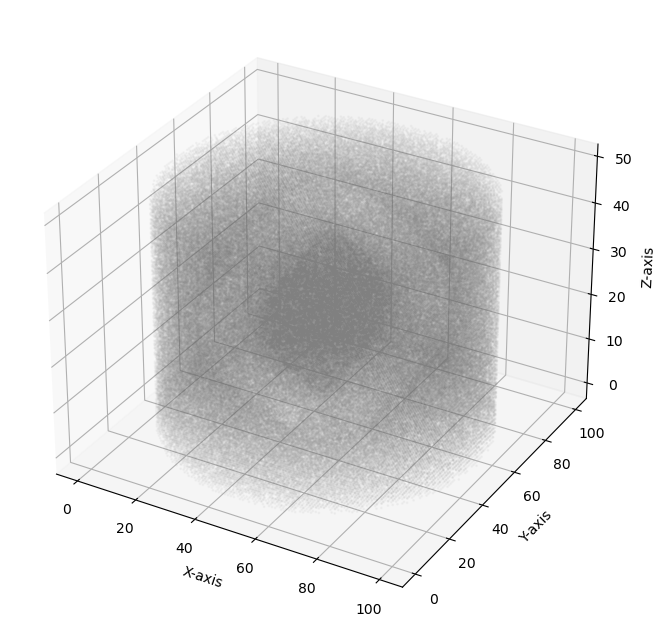

In [12]:
num_slices = 50
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i in range(num_slices):
    tissue_coord = simulated_slices[i].obsm['spatial']
    ax.scatter(tissue_coord[:,0], tissue_coord[:,1], np.full_like(tissue_coord[:,0], num_slices - i - 1), color='gray', alpha=0.05, s=1)
    
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

plt.show()

# Run MOSAICFlow morphological alignment

Let's choose two slices from this 3D stack that has some substantial morphology changes. We choose slice 7 and slice 10 here. You can see that the duct positions in the two slices do not match up, and we need something more than just affine transformation in order to register them.

Note that this is not the same experiment done in the manuscript. We just choose two slices that are sufficently different to illustrate the idea of morphological alignment and diffeomorphism.

In [15]:
slice_7 = simulated_slices[7]
slice_10 = simulated_slices[10]

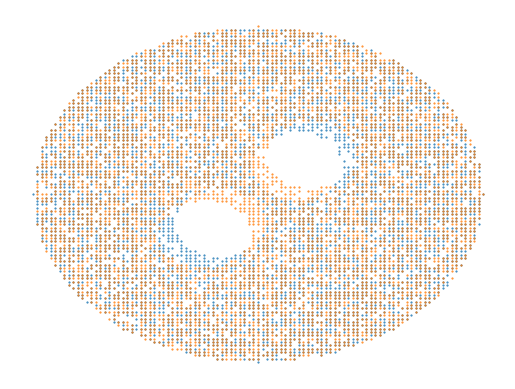

In [16]:
# Visualize the two slices on the same coordinate system
plot_slices_overlap([slice_7.obsm['spatial'], slice_10.obsm['spatial']], ['#1f77b4','#ff7f0e'], invert_axis=False, s=1)

Now we call MOSAICFlow morphological alignment through `MOSAICFlow.morphological.train_morphological_model`. `train_morphological_model` takes in a probabilistic mapping `P` as input, which typically comes from the physical alignment step. However, there is no need for physical alignment here since the slices already come from a 3D tissue model. Therefore, we use FGW-OT to compute the probabilistic mapping without invoking physical alignment.

After the flow model is trained, we use `MOSAICFlow.morphological.flow_morphology` to compute the morphological alignment of a set of input coordinates.

In [21]:
C = distance.cdist(slice_7.obsm['spatial'], slice_10.obsm['spatial'])
C /= C.max()
print(C.shape)

D_X = distance.cdist(slice_7.X, slice_7.X)
D_Y = distance.cdist(slice_10.X, slice_10.X)
D_X /= D_X.max()
D_Y /= D_Y.max()

P = ot.gromov.fused_gromov_wasserstein(C, D_X, D_Y, alpha=0.1)

max_iter = 50000  # number of iterations used to train the neural ODE, default 50000
model_save_name = 'PATH/TO/YOUR/model.pt'  # the path where you would like to save your model file
hidden_dims = [64,64,64]  # the dimensions of the hidden layer of the neural network
train_morphological_model(slice_7, slice_10, P, 
                    max_iter=max_iter, 
                    model_save_name=model_save_name, 
                    hidden_dims=hidden_dims, lr=0.005)  # train_morphological_model() will train the model based on P and save the model to model_save_name

# MOSAICFlow.morphological.flow_morphology() can be used for numerical integration for non-linear diffeomorphism registration.
# Given a model and a point cloud, flow_morphology() will integrate the model to compute a diffeomorphism-transformed point cloud.
_, slice7_coord_flowed = flow_morphology(model_path=model_save_name, X=slice_7.obsm['spatial'], hidden_dims=hidden_dims)

(4995, 4957)
Choose GPU:1 as device
iter 0 loss 5.1653151512146 time 0.010357141494750977
iter 2000 loss 1.0218425989151 time 12.713976383209229
iter 4000 loss 0.9732310175895691 time 12.598400592803955
iter 6000 loss 0.8281995058059692 time 12.665055990219116
iter 8000 loss 0.7928858995437622 time 12.667619943618774
iter 10000 loss 0.9207574725151062 time 12.661311626434326
iter 12000 loss 0.7927614450454712 time 12.733347177505493
iter 14000 loss 0.7608112692832947 time 13.389083862304688
iter 16000 loss 0.766440749168396 time 13.582520008087158
iter 18000 loss 0.788556694984436 time 13.696276187896729
iter 20000 loss 0.780613362789154 time 13.631537914276123
iter 22000 loss 0.7798426151275635 time 13.270735502243042
iter 24000 loss 0.874395489692688 time 13.261377811431885
iter 26000 loss 0.7933913469314575 time 13.253458023071289
iter 28000 loss 0.770142138004303 time 13.258287906646729
iter 30000 loss 0.8303078413009644 time 13.254105567932129
iter 32000 loss 0.7684868574142456 ti

Let's visualize the coordinates of the slices after morphological alignment. Slice 7 is now non-linearly registered onto slice 10, and the positions of the ducts match up.

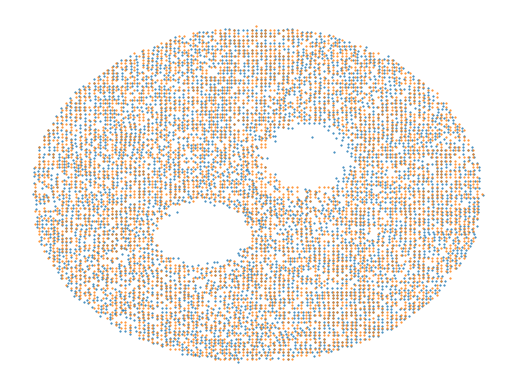

In [23]:
plot_slices_overlap([slice7_coord_flowed, slice_10.obsm['spatial']], ['#1f77b4','#ff7f0e'], invert_axis=False, s=1)